# Testing IME (Golub et al. 2015) on RNN data

March 29, 2022

_If I train an RNN to perform a reach-out task, what does IME predict?_

According to the documentation, data needs to be formatted as a MATLAB struct with the following fields:

* `spike_counts`: Binned spike counts. [1 x # trials] cell array. Each element is [# neurons x # timesteps].

* `cursor_position`: 2D cursor positions. [1 x # trials] cell array. Each element is [2 x # timesteps].

* `target_position`: 2D target positions. [1 x # trials] cell array. Each element is [2x1]. The fitting code will also accept time-varying target position, in which case this can be [2 x # timesteps].


For example, in Matlab I have the first element of `data.spike_counts` as 24 x 11 array, i.e. 24 neurons and 11 time steps. The binned spike counts range from 0-4. Another element is 24 x 15, i.e. 24 neurons and 15 timesteps.

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.io import savemat,loadmat

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.rflo import RFLO
from algorithms.bptt import BPTT
from algorithms.reinforce import REINFORCE
from algorithms.weight_mirror import WeightMirror
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories
from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation
from utils.functions import f, df

#### How to save data for .mat format as required by the IME code:

In [28]:

data=np.zeros((2,),dtype=np.object)
data[0] = np.asarray([[0,0,0,0],[1,1,1,1],[2,2,2,2]])
data[1] = np.asarray([[0,0,0,0],[1,1,1,1],[2,2,2,2]])


In [29]:
test = savemat('data_test.mat',{'data':data})

## Generate Training Data for "Perfect" Internal Model

Set the decoder/readout weights and train with perfect weight transport

In [3]:
trial_duration = 20
n_in=4
frac_on = 0.4 # notice here the input duration - this usually makes the task easier

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

8it [00:00, 78.39it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 8
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: 0.5
sig_fb: 0.01
feedback_signal: position
velocity_transform: True
tau_vel: 2
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fae4e8e4990>




1000it [00:03, 300.72it/s]
100it [00:00, 914.60it/s]



Net0 corr coef=1.000


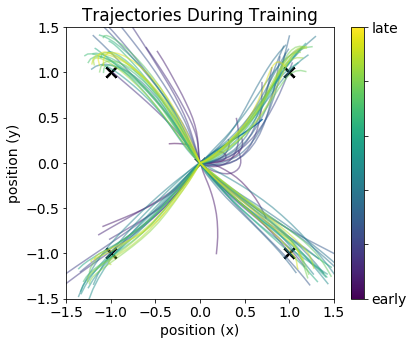

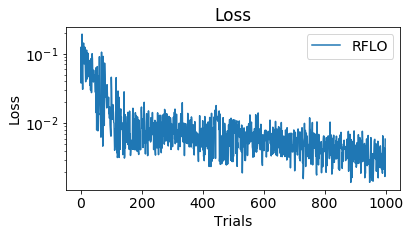

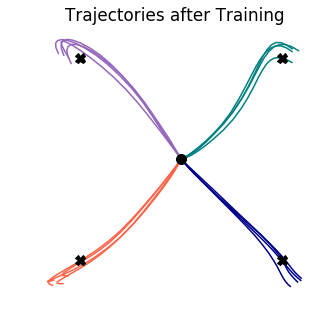

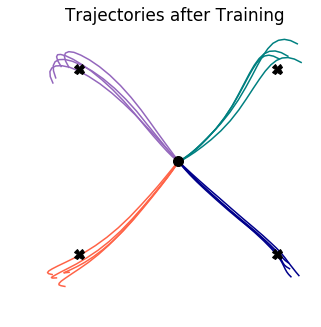

In [54]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=8,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1, eta_fb=0.5, 
               sig_in=0.01,sig_rec=0.1,sig_out=0.01, sig_fb=0.01,
               velocity_transform=True, tau_vel = 2, dt_vel = 0.1,
               driving_feedback=False,
               rng=np.random.RandomState(1))
params.print_params()
print('\n')

# Initialize RNN
net0 = RNN(params,f=f,df=df)

# initialize simulation
sim0 = Simulation(net0)


""" Train Network """

rflo = RFLO(net0,apply_to=['w_rec','w_out']) 
sim0.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=10)

corrcoef = np.corrcoef(net0.w_m.T.ravel(),net0.w_out.ravel())[0,1]
print('\nNet0 corr coef={:.3f}'.format(corrcoef))

fig = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4])

""" Store activity after learning """
trackvars = TrackVars(net0,apply_to=[]) 
sim0.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','pos','task'], plot=False, plot_freq=10)
fig = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4])

In [86]:
# The algorithm assumes that the trial ends once the cursor reaches the target
#
# for each trial, shave off timesteps after cursor is close to the target
epsilon = 0.08
final_timestep=[]
for i,(pos,task) in enumerate(zip(sim0.session_probes['pos'],sim0.session_probes['task'])):
    
    for j,p in enumerate(pos):
        delta = np.linalg.norm(p - task.y_target)
        if delta < epsilon:
            #print('continue \n')
            break
            
        #print(j)
    final_timestep.append(j)
            
        
# final timestep shhould countain indices ranging from ~10 to 19

In [88]:

cut_trajectory = True


""" Spike Counts """
spike_counts = np.zeros((len(sim0.session_probes['h']),),dtype=np.object)

for i,h in enumerate(sim0.session_probes['h']):
    spike_counts[i] = h.squeeze().T # note transpose here, so that we have number of neurons x number of trials
    
    if cut_trajectory:
        spike_counts[i] = h.squeeze().T[:,:final_timestep[i]]
    
    
""" Cursor Position """
cursor_position = np.zeros((len(sim0.session_probes['pos']),),dtype=np.object)

for i,pos in enumerate(sim0.session_probes['pos']):
    cursor_position[i] = pos.squeeze().T # 2 x number of timesteps
    
    if cut_trajectory:
        cursor_position[i] = pos.squeeze().T[:,:final_timestep[i]]
    
""" Target Positions """
target_position = np.zeros((len(sim0.session_probes['task']),),dtype=np.object)

for i,task in enumerate(sim0.session_probes['task']):
    target_position[i] = np.asarray(task.y_target,dtype = np.float64) # 2 x 1, necessary to cast as a float64

In [89]:
sample_data = savemat('sample_data2.mat',{'spike_counts':spike_counts,'cursor_position':cursor_position,'target_position':target_position})

### Load data from Mat file

In [90]:
B = loadmat('B_test2-1000.mat')['B']

In [91]:
# Compare Alignment with True Readout

corrcoef = np.corrcoef(B.ravel(),net0.w_out.ravel())[0,1]
print('\nAlignment of IME matrix with readout: corr coef={:.3f}'.format(corrcoef))

corrcoef = np.corrcoef(B.ravel(),net0.w_m.T.ravel())[0,1]
print('\nAlignment of IME matrix with w_m.T: corr coef={:.3f}'.format(corrcoef))


Alignment of IME matrix with readout: corr coef=0.598

Alignment of IME matrix with w_m.T: corr coef=0.598


### Compare Network substituted with IME Matrix B

100it [00:00, 515.01it/s]


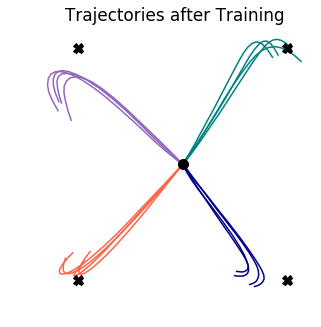

In [94]:
net0_b = RNN(params,f=f,df=df)
net0_b.set_weights(w_in = net0.w_in.copy(),w_rec = net0.w_rec.copy(),w_m = net0.w_m.copy())
net0_b.set_weights(w_out = 10*B)

sim0_b = Simulation(net0_b)

""" Store activity after learning """
trackvars = TrackVars(net0_b,apply_to=[]) 
sim0_b.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=[], plot=False, plot_freq=10)
fig = plot_trained_trajectories(sim=sim0_b, tasks=[task1,task2,task3,task4])

## Generate Training Data for "Biased" Internal Model


8it [00:00, 77.97it/s]


Alignment of internal model with readout: corr coef=0.376


100it [00:00, 202.11it/s]
67it [00:00, 650.54it/s]


Net1 Alignment after weight mirroring: corr coef=0.376


100it [00:00, 576.10it/s]


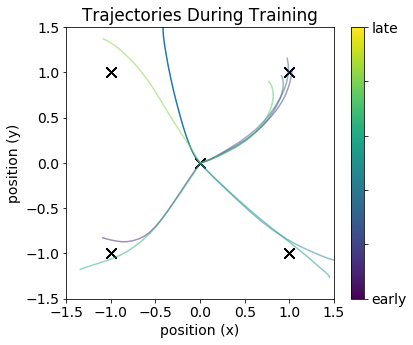

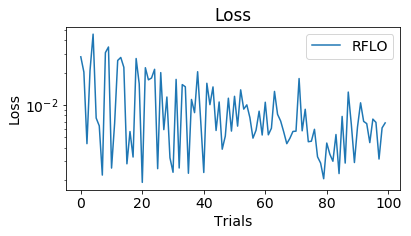

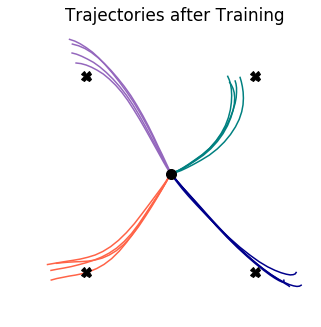

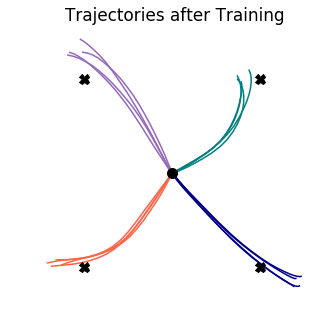

In [102]:
net1 = RNN(params,f=f,df=df)


""" Create Partially Aligned Internal Model"""
sig_w_m = 0.6
w_m = np.copy(net0.w_out.T) + sig_w_m*np.random.RandomState(0).randn(net0.w_out.T.shape[0],net0.w_out.T.shape[1]) # keep random value constant

corrcoef = np.corrcoef(w_m.T.ravel(),net0.w_out.ravel())[0,1]
print('\nAlignment of internal model with readout: corr coef={:.3f}'.format(corrcoef))

sim1 = Simulation(net1)

net1.set_weights(w_m = w_m)
net1.set_weights(w_out = net0.w_out.copy())

""" Simulation with Biased Internal Model """

rflo = RFLO(net1,apply_to=['w_rec']) 
sim1.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=10)

corrcoef = np.corrcoef(net1.w_m.T.ravel(),net1.w_out.ravel())[0,1]
print('\nNet1 Alignment after weight mirroring: corr coef={:.3f}'.format(corrcoef))
fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4])

""" Store activity after learning """
trackvars = TrackVars(net0,apply_to=[]) 
sim1.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','pos','task'], plot=False, plot_freq=10)
fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4])

In [103]:
# The algorithm assumes that the trial ends once the cursor reaches the target
#
# for each trial, shave off timesteps after cursor is close to the target
epsilon = 0.08
final_timestep=[]
for i,(pos,task) in enumerate(zip(sim1.session_probes['pos'],sim1.session_probes['task'])):
    
    for j,p in enumerate(pos):
        delta = np.linalg.norm(p - task.y_target)
        if delta < epsilon:
            #print('continue \n')
            break
            
        #print(j)
    final_timestep.append(j)
            
        
# final timestep shhould countain indices ranging from ~10 to 19

In [104]:

cut_trajectory = True


""" Spike Counts """
spike_counts = np.zeros((len(sim1.session_probes['h']),),dtype=np.object)

for i,h in enumerate(sim1.session_probes['h']):
    spike_counts[i] = h.squeeze().T # note transpose here, so that we have number of neurons x number of trials
    
    if cut_trajectory:
        spike_counts[i] = h.squeeze().T[:,:final_timestep[i]]
    
    
""" Cursor Position """
cursor_position = np.zeros((len(sim1.session_probes['pos']),),dtype=np.object)

for i,pos in enumerate(sim1.session_probes['pos']):
    cursor_position[i] = pos.squeeze().T # 2 x number of timesteps
    
    if cut_trajectory:
        cursor_position[i] = pos.squeeze().T[:,:final_timestep[i]]
    
""" Target Positions """
target_position = np.zeros((len(sim1.session_probes['task']),),dtype=np.object)

for i,task in enumerate(sim1.session_probes['task']):
    target_position[i] = np.asarray(task.y_target,dtype = np.float64) # 2 x 1, necessary to cast as a float64

In [105]:
sample_data = savemat('sample_data3.mat',{'spike_counts':spike_counts,'cursor_position':cursor_position,'target_position':target_position})

### Load data from Mat file

In [90]:
B = loadmat('B_test3-1000.mat')['B']

In [106]:
# Compare Alignment with True Readout

corrcoef = np.corrcoef(B.ravel(),net1.w_out.ravel())[0,1]
print('\nAlignment of IME matrix with readout: corr coef={:.3f}'.format(corrcoef))

corrcoef = np.corrcoef(B.ravel(),net1.w_m.T.ravel())[0,1]
print('\nAlignment of IME matrix with w_m.T: corr coef={:.3f}'.format(corrcoef))


Alignment of IME matrix with readout: corr coef=0.598

Alignment of IME matrix with w_m.T: corr coef=0.412


### Compare Network substituted with IME Matrix B

100it [00:00, 471.78it/s]


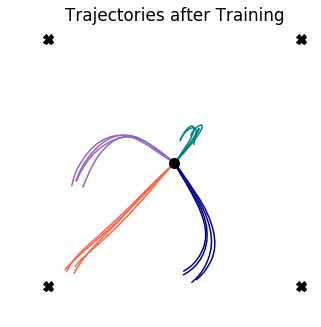

In [110]:
net1_b = RNN(params,f=f,df=df)
net1_b.set_weights(w_in = net1.w_in.copy(),w_rec = net1.w_rec.copy(),w_m = net1.w_m.copy())
net1_b.set_weights(w_out = 5*B)

sim1_b = Simulation(net1_b)

""" Store activity after learning """
trackvars = TrackVars(net1_b,apply_to=[]) 
sim1_b.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=[], plot=False, plot_freq=10)
fig = plot_trained_trajectories(sim=sim1_b, tasks=[task1,task2,task3,task4])

# Incorporate Driving Feedback

5it [00:00, 48.73it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 8
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: True
eta_fb: 0.5
sig_fb: 0.01
feedback_signal: position
velocity_transform: True
tau_vel: 2
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fae4cae0708>




1000it [00:04, 206.13it/s]
100it [00:00, 724.82it/s]


Net0 corr coef=1.000


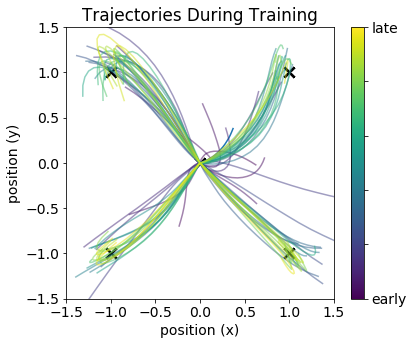

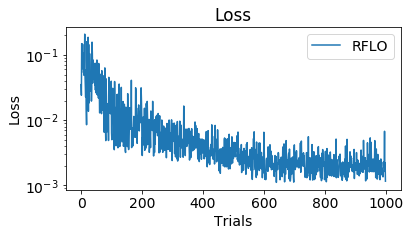

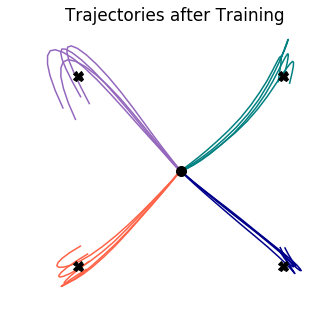

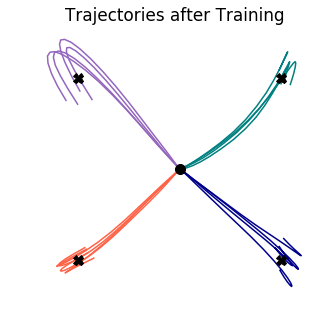

In [111]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=8,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1, eta_fb=0.5, 
               sig_in=0.01,sig_rec=0.1,sig_out=0.01, sig_fb=0.01,
               velocity_transform=True, tau_vel = 2, dt_vel = 0.1,
               driving_feedback=True,
               rng=np.random.RandomState(1))
params.print_params()
print('\n')

# Initialize RNN
net2 = RNN(params,f=f,df=df)

# initialize simulation
sim2 = Simulation(net2)


""" Train Network """

rflo = RFLO(net2,apply_to=['w_rec','w_out','w_fb']) 
sim2.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=10)

corrcoef = np.corrcoef(net2.w_m.T.ravel(),net2.w_out.ravel())[0,1]
print('\nNet0 corr coef={:.3f}'.format(corrcoef))

fig = plot_trained_trajectories(sim=sim2, tasks=[task1,task2,task3,task4])

""" Store activity after learning """
trackvars = TrackVars(net2,apply_to=[]) 
sim2.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','pos','task'], plot=False, plot_freq=10)
fig = plot_trained_trajectories(sim=sim2, tasks=[task1,task2,task3,task4])

In [114]:
corrcoef = np.corrcoef(net2.w_fb.T.ravel(),net2.w_out.ravel())[0,1]
print('\nAlignment of w_fb matrix with readout: corr coef={:.3f}'.format(corrcoef))




Alignment of w_fb matrix with readout: corr coef=-0.452


In [115]:
# The algorithm assumes that the trial ends once the cursor reaches the target
#
# for each trial, shave off timesteps after cursor is close to the target
epsilon = 0.08
final_timestep=[]
for i,(pos,task) in enumerate(zip(sim2.session_probes['pos'],sim2.session_probes['task'])):
    
    for j,p in enumerate(pos):
        delta = np.linalg.norm(p - task.y_target)
        if delta < epsilon:
            #print('continue \n')
            break
            
        #print(j)
    final_timestep.append(j)
            
        
# final timestep shhould countain indices ranging from ~10 to 19

In [116]:

cut_trajectory = True


""" Spike Counts """
spike_counts = np.zeros((len(sim2.session_probes['h']),),dtype=np.object)

for i,h in enumerate(sim2.session_probes['h']):
    spike_counts[i] = h.squeeze().T # note transpose here, so that we have number of neurons x number of trials
    
    if cut_trajectory:
        spike_counts[i] = h.squeeze().T[:,:final_timestep[i]]
    
    
""" Cursor Position """
cursor_position = np.zeros((len(sim2.session_probes['pos']),),dtype=np.object)

for i,pos in enumerate(sim2.session_probes['pos']):
    cursor_position[i] = pos.squeeze().T # 2 x number of timesteps
    
    if cut_trajectory:
        cursor_position[i] = pos.squeeze().T[:,:final_timestep[i]]
    
""" Target Positions """
target_position = np.zeros((len(sim2.session_probes['task']),),dtype=np.object)

for i,task in enumerate(sim2.session_probes['task']):
    target_position[i] = np.asarray(task.y_target,dtype = np.float64) # 2 x 1, necessary to cast as a float64

In [117]:
sample_data = savemat('sample_data4.mat',{'spike_counts':spike_counts,'cursor_position':cursor_position,'target_position':target_position})

### Load data from Mat file

In [118]:
B = loadmat('B_test4-1000.mat')['B']

In [119]:
# Compare Alignment with True Readout

corrcoef = np.corrcoef(B.ravel(),net2.w_out.ravel())[0,1]
print('\nAlignment of IME matrix with readout: corr coef={:.3f}'.format(corrcoef))

corrcoef = np.corrcoef(B.ravel(),net2.w_m.T.ravel())[0,1]
print('\nAlignment of IME matrix with w_m.T: corr coef={:.3f}'.format(corrcoef))

corrcoef = np.corrcoef(B.ravel(),net2.w_fb.T.ravel())[0,1]
print('\nAlignment of IME matrix with w_fb.T: corr coef={:.3f}'.format(corrcoef))


Alignment of IME matrix with readout: corr coef=0.491

Alignment of IME matrix with w_m.T: corr coef=0.491

Alignment of IME matrix with w_fb.T: corr coef=-0.343


### Compare Network substituted with IME Matrix B

100it [00:00, 452.90it/s]


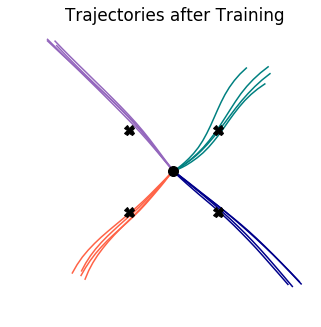

In [138]:
net2_b = RNN(params,f=f,df=df)
net2_b.set_weights(w_in = net2.w_in.copy(),w_rec = net2.w_rec.copy(),w_m = net2.w_m.copy())
net2_b.set_weights(w_out = net2.w_out.copy())
#net2_b.set_weights(w_out = 10*B)
net2_b.set_weights(w_fb = B.T)
#net2_b.set_weights(w_fb = net2.w_fb.copy())

sim2_b = Simulation(net2_b)

""" Store activity after learning """
trackvars = TrackVars(net2_b,apply_to=[]) 
sim2_b.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=[], plot=False, plot_freq=10)
fig = plot_trained_trajectories(sim=sim2_b, tasks=[task1,task2,task3,task4])

# Driving Feedback with Biased Internal Model

2it [00:00, 19.08it/s]


Alignment of internal model with readout: corr coef=0.578


1000it [00:03, 254.21it/s]
100it [00:00, 741.72it/s]



Net0 corr coef=0.182


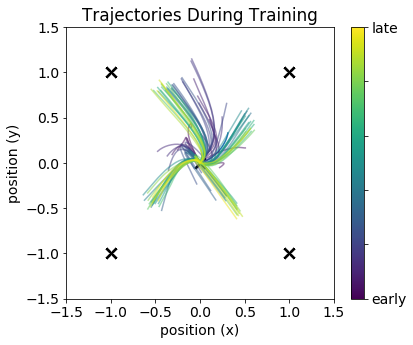

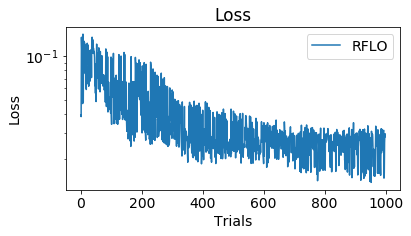

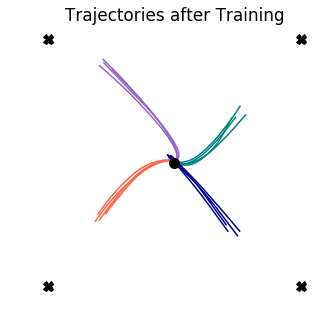

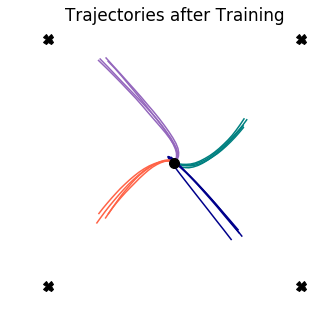

In [153]:
net3 = RNN(params,f=f,df=df)

""" Create Partially Aligned Internal Model"""
sig_w_m = 0.4
w_m = np.copy(net2.w_out.T) + sig_w_m*np.random.RandomState(0).randn(net2.w_out.T.shape[0],net2.w_out.T.shape[1]) # keep random value constant

corrcoef = np.corrcoef(w_m.T.ravel(),net2.w_out.ravel())[0,1]
print('\nAlignment of internal model with readout: corr coef={:.3f}'.format(corrcoef))



net3.set_weights(w_m = w_m)
net3.set_weights(w_out = net3.w_out.copy(),w_in = net2.w_in.copy(),w_fb = net2.w_fb.copy())
# Initialize RNN


# initialize simulation
sim3 = Simulation(net3)


""" Train Network """

rflo = RFLO(net3,apply_to=['w_rec','w_fb']) 
sim3.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=10)

corrcoef = np.corrcoef(net3.w_m.T.ravel(),net3.w_out.ravel())[0,1]
print('\nNet0 corr coef={:.3f}'.format(corrcoef))

fig = plot_trained_trajectories(sim=sim3, tasks=[task1,task2,task3,task4])

""" Store activity after learning """
trackvars = TrackVars(net3,apply_to=[]) 
sim3.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','pos','task'], plot=False, plot_freq=10)
fig = plot_trained_trajectories(sim=sim3, tasks=[task1,task2,task3,task4])

In [154]:
corrcoef = np.corrcoef(net3.w_fb.T.ravel(),net3.w_out.ravel())[0,1]
print('\nAlignment of w_fb matrix with readout: corr coef={:.3f}'.format(corrcoef))

corrcoef = np.corrcoef(net3.w_fb.T.ravel(),net3.w_m.T.ravel())[0,1]
print('\nAlignment of w_fb matrix with w_m: corr coef={:.3f}'.format(corrcoef))




Alignment of w_fb matrix with readout: corr coef=-0.154

Alignment of w_fb matrix with w_m: corr coef=-0.263


In [155]:
# The algorithm assumes that the trial ends once the cursor reaches the target
#
# for each trial, shave off timesteps after cursor is close to the target
epsilon = 0.08
final_timestep=[]
for i,(pos,task) in enumerate(zip(sim3.session_probes['pos'],sim3.session_probes['task'])):
    
    for j,p in enumerate(pos):
        delta = np.linalg.norm(p - task.y_target)
        if delta < epsilon:
            #print('continue \n')
            break
            
        #print(j)
    final_timestep.append(j)
            
        
# final timestep shhould countain indices ranging from ~10 to 19

In [156]:

cut_trajectory = True


""" Spike Counts """
spike_counts = np.zeros((len(sim3.session_probes['h']),),dtype=np.object)

for i,h in enumerate(sim3.session_probes['h']):
    spike_counts[i] = h.squeeze().T # note transpose here, so that we have number of neurons x number of trials
    
    if cut_trajectory:
        spike_counts[i] = h.squeeze().T[:,:final_timestep[i]]
    
    
""" Cursor Position """
cursor_position = np.zeros((len(sim3.session_probes['pos']),),dtype=np.object)

for i,pos in enumerate(sim3.session_probes['pos']):
    cursor_position[i] = pos.squeeze().T # 2 x number of timesteps
    
    if cut_trajectory:
        cursor_position[i] = pos.squeeze().T[:,:final_timestep[i]]
    
""" Target Positions """
target_position = np.zeros((len(sim3.session_probes['task']),),dtype=np.object)

for i,task in enumerate(sim3.session_probes['task']):
    target_position[i] = np.asarray(task.y_target,dtype = np.float64) # 2 x 1, necessary to cast as a float64

In [157]:
sample_data = savemat('sample_data5.mat',{'spike_counts':spike_counts,'cursor_position':cursor_position,'target_position':target_position})

### Load data from Mat file

In [158]:
B = loadmat('B_test5-1000.mat')['B']

In [159]:
# Compare Alignment with True Readout

corrcoef = np.corrcoef(B.ravel(),net3.w_out.ravel())[0,1]
print('\nAlignment of IME matrix with readout: corr coef={:.3f}'.format(corrcoef))

corrcoef = np.corrcoef(B.ravel(),net3.w_m.T.ravel())[0,1]
print('\nAlignment of IME matrix with w_m.T: corr coef={:.3f}'.format(corrcoef))

corrcoef = np.corrcoef(B.ravel(),net3.w_fb.T.ravel())[0,1]
print('\nAlignment of IME matrix with w_fb.T: corr coef={:.3f}'.format(corrcoef))


Alignment of IME matrix with readout: corr coef=-0.259

Alignment of IME matrix with w_m.T: corr coef=0.250

Alignment of IME matrix with w_fb.T: corr coef=-0.085


### Compare Network substituted with IME Matrix B

100it [00:00, 639.21it/s]


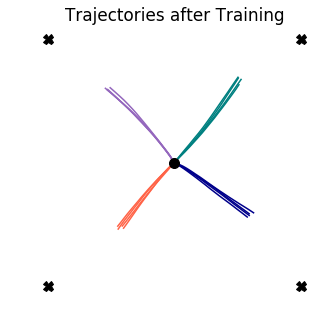

In [165]:
net3_b = RNN(params,f=f,df=df)
net3_b.set_weights(w_in = net3.w_in.copy(),w_rec = net3.w_rec.copy(),w_m = net3.w_m.copy())
#net3_b.set_weights(w_out = net3.w_out.copy())
net3_b.set_weights(w_out = 10*B)
net3_b.set_weights(w_fb = B.T)
#net3_b.set_weights(w_fb = net3.w_fb.copy())

sim3_b = Simulation(net3_b)

""" Store activity after learning """
trackvars = TrackVars(net3_b,apply_to=[]) 
sim3_b.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=[], plot=False, plot_freq=10)
fig = plot_trained_trajectories(sim=sim3_b, tasks=[task1,task2,task3,task4])

In [ ]:
""" Create Partially Aligned Internal Model"""
sig_w_m = 0.6
w_m = np.copy(net0.w_out.T) + sig_w_m*np.random.RandomState(0).randn(net0.w_out.T.shape[0],net0.w_out.T.shape[1]) # keep random value constant

corrcoef = np.corrcoef(w_m.T.ravel(),net0.w_out.ravel())[0,1]
print('\nAlignment of internal model with readout: corr coef={:.3f}'.format(corrcoef))

sim1 = Simulation(net1)

net1.set_weights(w_m = w_m)